<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Dyna-Q Planning Steps Sweep</strong></h2>
</div> 

&nbsp;

In classical model-free reinforcement learning (like Q-Learning or SARSA), the agent learns only from real experience gathered in the environment. This makes learning slow, because every update requires executing an actual step.
**Dyna-Q** improves on this by combining:

1. **Model-free TD Learning** (real interactions)
2. **Model-based planning** (simulated updates from a learned model)

This model provides a powerful idea:

    "If the agent has a learned model of the environment, it can update the Q-values many times per real experience"

The parameter **K (planning steps)** controls how many simulated updates the agent performs after each real step.

A sweep over K lets the user answer key questions, like:

* How much does planning accelerate learning?
* Does increasing K always help, or is there a point of diminishing returns?
* What value of $K$ gives the best compromise between computer cost and learning speed?
* Does too much planning cause instability, overfitting, or noisy updates?
* How do final policies compare when trained with different levels of planning?

These questions matter because Dyna-Q is the foundation of many modern RL and robotic algorithms, where planning itself can be expensive and must be tuned carefully.


**Index for analisis**

    * Learning Curve per K
    * Steps curves per K
    * Table: Ecpisodes to reach threshold return
    * Final Greedy paths per K

    
By running a **planning-step sweep ($K in {0, 5, 10, 20, 50}$), we can empirically observe:
* $K = 0$ -> pure model-free baseline
* Small $K$ -> modest improvement
* Medium $K$ -> often optimal balance
* Very Large $K$ -> diminishing returns or no improvement

**Goal**: This experiment helps build an intuition for **why Dyna-Q works**, how the model accelerates learning, and how planning interacts with experience.

---

## 1) Import & Environment Setup
This section imports all the necessary code and libraries. (There will be an `environment setup` in every notebook, it is necessary for the correct functioning of the algorithms and future analysis)

In [1]:
# ---  Notebook Setup ----------------------------------------------------
import sys, os
from pathlib import Path
from IPython import get_ipython
import importlib
import matplotlib.pyplot as plt
from dataclasses import dataclass, replace
from typing import Optional, List, Dict, Tuple
import numpy as np

GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"

try:
    root = Path.cwd()
    src_path = (root / "../src").resolve()

    # 1) Make sure local ../src wins over site-packages
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    ip = get_ipython()
    if ip:
        ip.run_line_magic("load_ext", "autoreload")
        ip.run_line_magic("autoreload", "2")

    # 2) Import and *verify* we’re loading the right files
    import rl_capstone
    import rl_capstone.rl_algorithms as rla
    print("rl_capstone from:", getattr(rl_capstone, "__file__", "?"))
    print("rl_algorithms from:", getattr(rla, "__file__", "?"))

    # 3) Force a reload in case kernel already loaded the old one
    importlib.reload(rla)

    # 4) Now import the names (after reload)
    from rl_capstone import GridWorld, WorldSettings
    
    from rl_capstone.rl_algorithms import (
        TrainConfig,
        q_learning_train_with_logs,
        sarsa_train_with_logs,
        dyna_q_train_with_logs,
    )

    from rl_capstone.utils import (
        evaluate_policy,
        greedy_policy_from_0,
        plot_learning_curve,
        EpisodeLog,
        greedy_action,
        run_greedy_episode,
        rolling,
        idx_traj_to_rc_path,
        value_grid,
    plot_value_and_policy,
)


    print(f"{GREEN}Environment setup complete!{RESET}")

except Exception as e:
    print(f"{RED}Setup failed:{RESET}", e)

rl_capstone from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/__init__.py
rl_algorithms from: /Users/houndsito/Documents/Development/github/fcampoverdeg/reinforcement_learning/src/rl_capstone/rl_algorithms.py
Environment setup complete!


## 2) Build & Preview the environment
This section is for visualization purposes, the user can see the world where the agent will be performing its tasks, this can be changed by the user by adding walls, pits, changing the position of the starting point and the goal, as well as the size of the Grid World.

(For more information on how to use the `GridWorld` class please check: [GridWorld](../src/rl_capstone/rl_algorithms.py))


States=121, Actions=4, Grid=11x11



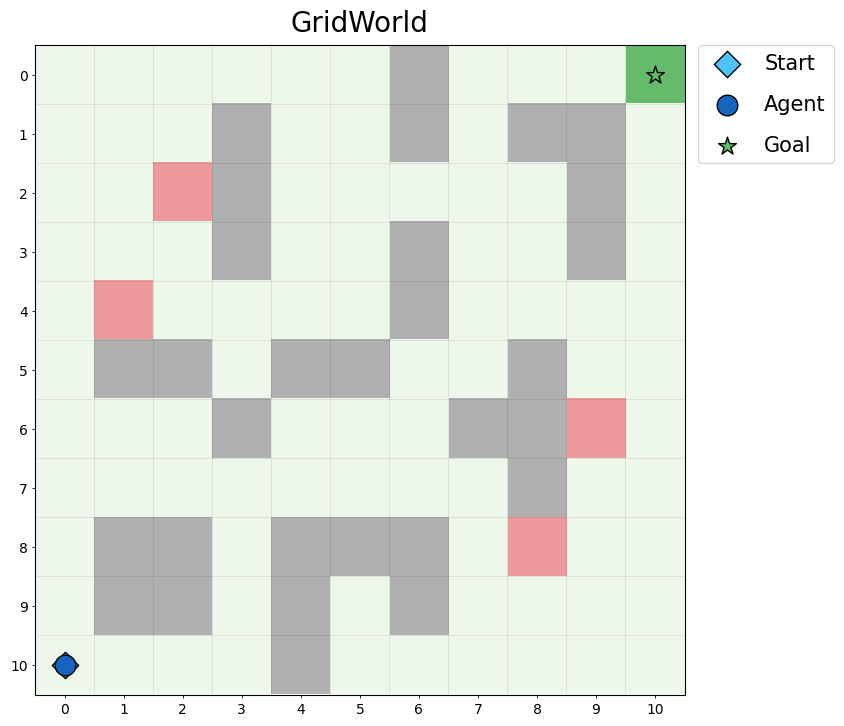

In [2]:
# Instantiate environment with your WorldSettings
settings = WorldSettings()      # tweak if you want a different map
env = GridWorld(settings)
env.seed(7)

print(f"\nStates={env.num_states}, Actions={env.num_actions}, Grid={env.rows}x{env.cols}\n")

env.render(title="GridWorld")

## 3) Log Config

This section controls how often the log training progress is and how many episodes are run to measure greedy performance at each snapshot.

Users can change the limit of snapshots, episodes and seed, which will affect factors like: `Wind randomness`, `Transition noise`, `Length and returns of greedy evaluation episodes`.

In [3]:
# Tweak depending on user preferences
@dataclass
class LogConfig:
    snapshot_every: int = 40    # take a snapshot every N episodes
    eval_episodes: int = 5      # greedy evals per snapshot
    seed: Optional[int] = 7

print(f"{GREEN}Log Config Setup!{RESET}")

Log Config Setup!


## 4) Train Configuration + Log Config
In this section the user can set up the configurations needed for training the agent.

In [4]:
cfg = TrainConfig(
    episodes=750,
    max_steps=1000,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=10_000,
    seed=42,
    q_init=0.0
)

logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

## 5) Training Learning Models and Storage
In this section, the user trains the machine learning model with the configuration set previously.

In [5]:
results = {}

# ---- Train Dyna-Q ---- #
try:
    print("Training Dyna-Q...")
    Q_d, logs_d = dyna_q_train_with_logs(env, cfg, logcfg)
    results ["Dyna-Q"] = {"Q": Q_d, "logs": logs_d}
    
except Exception as e:
    print(f"{RED} [ERROR] Dyna-Q failed:{RESET}", e)
    Q_d = None

print(f"{GREEN}Dyna-Q Model Training finished (with above warnings if any).{RESET}")

Training Dyna-Q...
Dyna-Q Model Training finished (with above warnings if any).


## 6) Loop Over K Values
Now, the user can test Dyna-Q's algorithm under different values of K, and see how it behaves.

In [6]:
try:
    K_values = [0, 5, 10, 20, 50]   # K=0 ≈ pure model-free baseline
    dyna_K_results = {}
    
    for K in K_values:
        print(f"Running Dyna-Q with K={K} planning steps...")
        cfg_K = replace(cfg, planning_steps=K)  # same cfg, different K
        Q_K, logs_K = dyna_q_train_with_logs(env, cfg_K, logcfg)
        dyna_K_results[K] = {"Q": Q_K, "logs": logs_K}
        
    print(f"{GREEN}Done!{RESET}")

except Exception as e:
    print(f"{RED}Process Failed:{RESET}", e)

Running Dyna-Q with K=0 planning steps...
Running Dyna-Q with K=5 planning steps...
Running Dyna-Q with K=10 planning steps...
Running Dyna-Q with K=20 planning steps...
Running Dyna-Q with K=50 planning steps...
Done!


## 7) Plot Learning Curves for Different K

In this section, the user can plot the performance of Dyna-Q with different K. **Returns vs Episodes**


=== Final Policy Evaluation for Dyna-Q (different K values) ===

K = 0 — mean return: 0.778, mean steps: 23.2
K = 5 — mean return: 0.780, mean steps: 23.0
K = 10 — mean return: 0.778, mean steps: 23.2
K = 20 — mean return: 0.780, mean steps: 23.0
K = 50 — mean return: 0.776, mean steps: 23.4



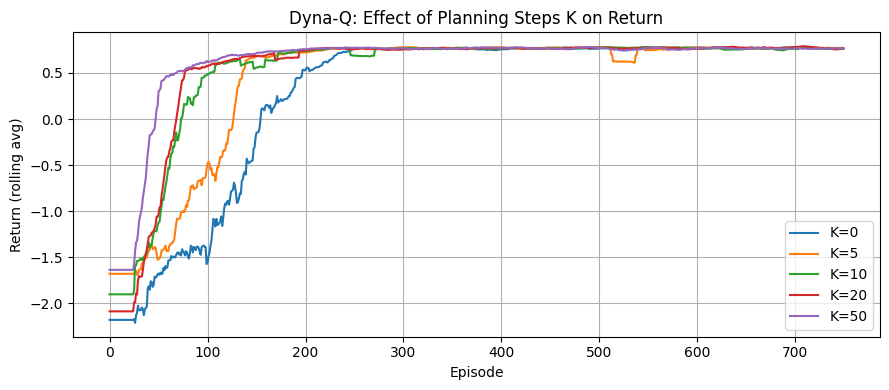

In [7]:
# === Final Evaluation for Each K (30 greedy episodes) ===

print("\n=== Final Policy Evaluation for Dyna-Q (different K values) ===\n")

for K, res in dyna_K_results.items():
    Q = res["Q"]                           # Extract Q-table
    pi = greedy_policy_from_0(Q)           # Build greedy policy
    mean_return, mean_len = evaluate_policy(
        env,
        pi,
        episodes=30,
        max_steps=1000,
        seed=123  # fixed seed for fairness
    )
    print(f"K = {K} — mean return: {mean_return:.3f}, mean steps: {mean_len:.1f}")
print()  # clean spacing

# === Plot Learning Curves for Different K Values ===

plt.figure(figsize=(9,4))

for K, res in dyna_K_results.items():
    returns = res["logs"]["returns"]
    smooth = rolling(returns, 25)
    plt.plot(smooth, label=f"K={K}")

plt.title("Dyna-Q: Effect of Planning Steps K on Return")
plt.xlabel("Episode")
plt.ylabel("Return (rolling avg)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("../reports/figs/k_sweeping/ksweep_return.png", dpi=300, bbox_inches="tight")
plt.show()

The following code is to plot the performance of Dyna-Q with respect to **Steps vs Episodes**

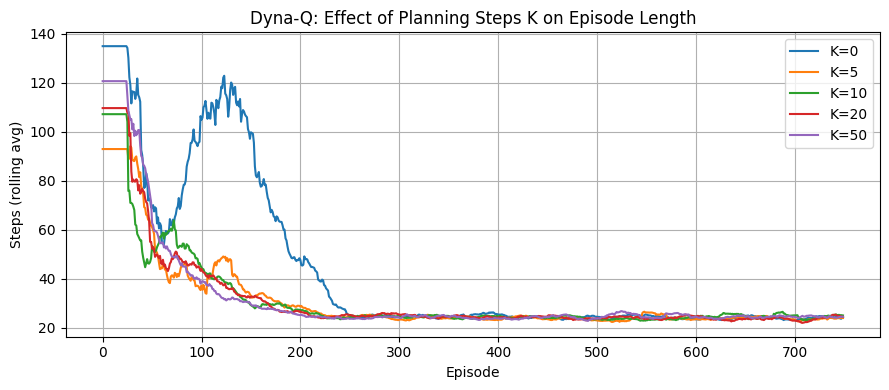

In [8]:
plt.figure(figsize=(9,4))

for K, res in dyna_K_results.items():
    steps = res["logs"]["steps"]
    smooth = rolling(steps, 25)
    plt.plot(smooth, label=f"K={K}")

plt.title("Dyna-Q: Effect of Planning Steps K on Episode Length")
plt.xlabel("Episode")
plt.ylabel("Steps (rolling avg)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("../reports/figs/k_sweeping/ksweep_steps.png", dpi=300, bbox_inches="tight")
plt.show()

## 8) Final Greedy Path for Different K

This section prints the last outcome from the algorithm using different K values, showing the "most" optimal outputs. It provides the average `result` and `steps` the agent took during the algorithm.

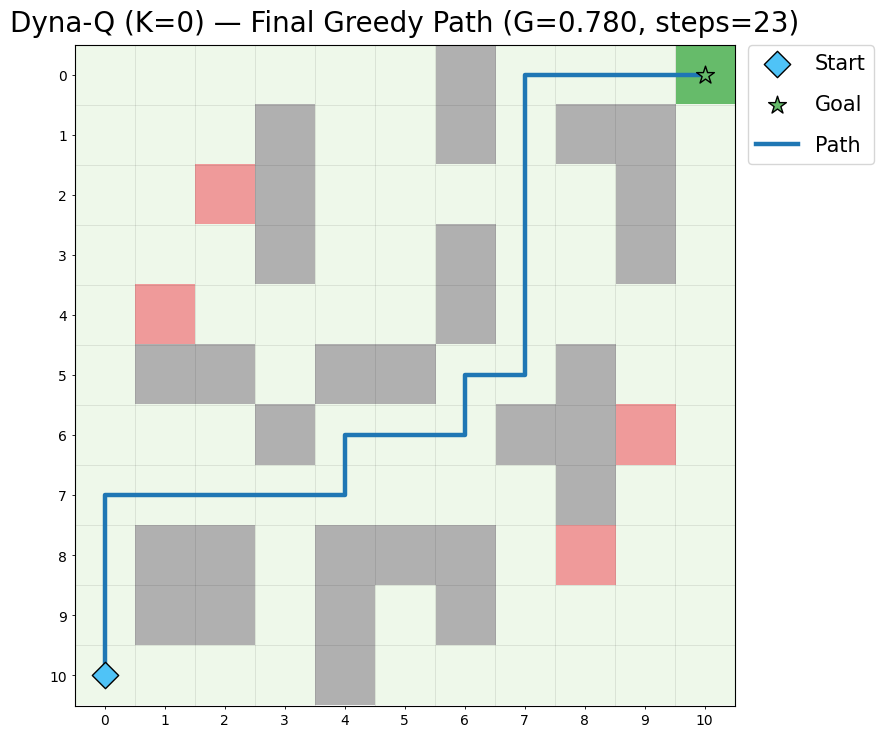

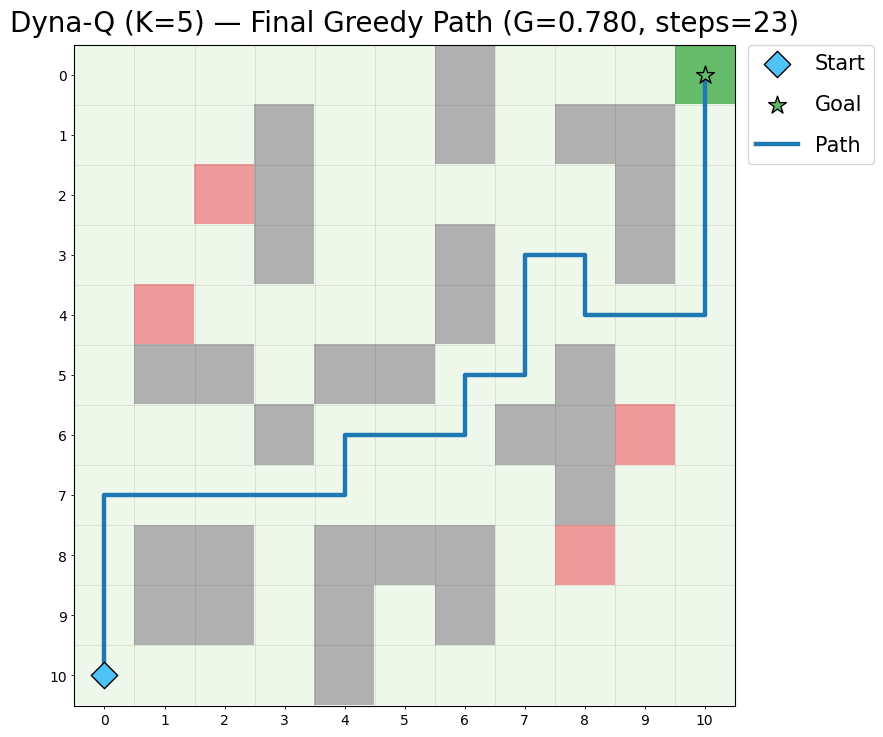

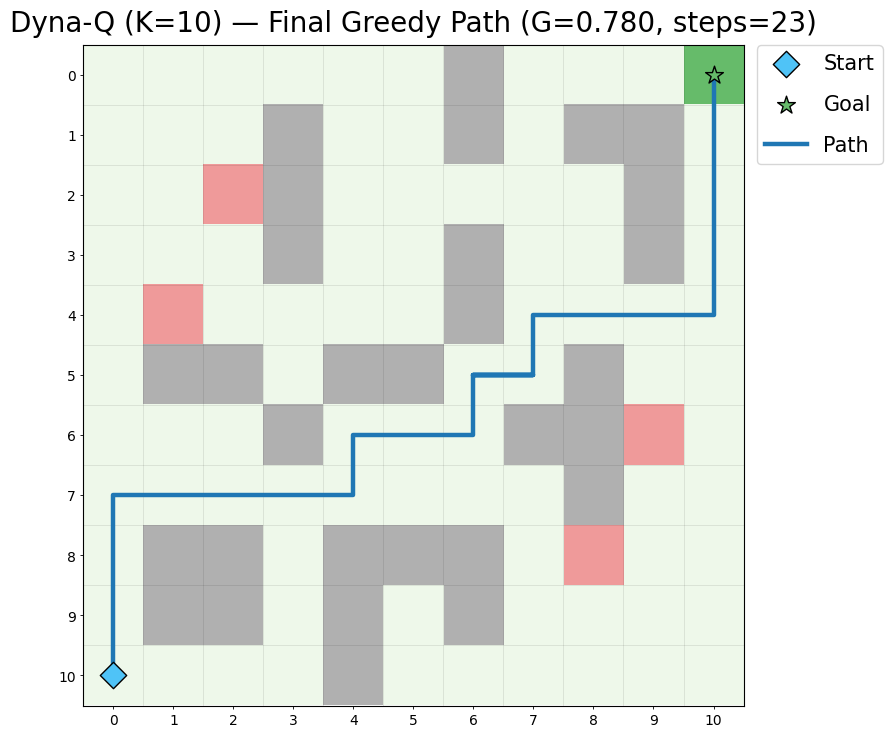

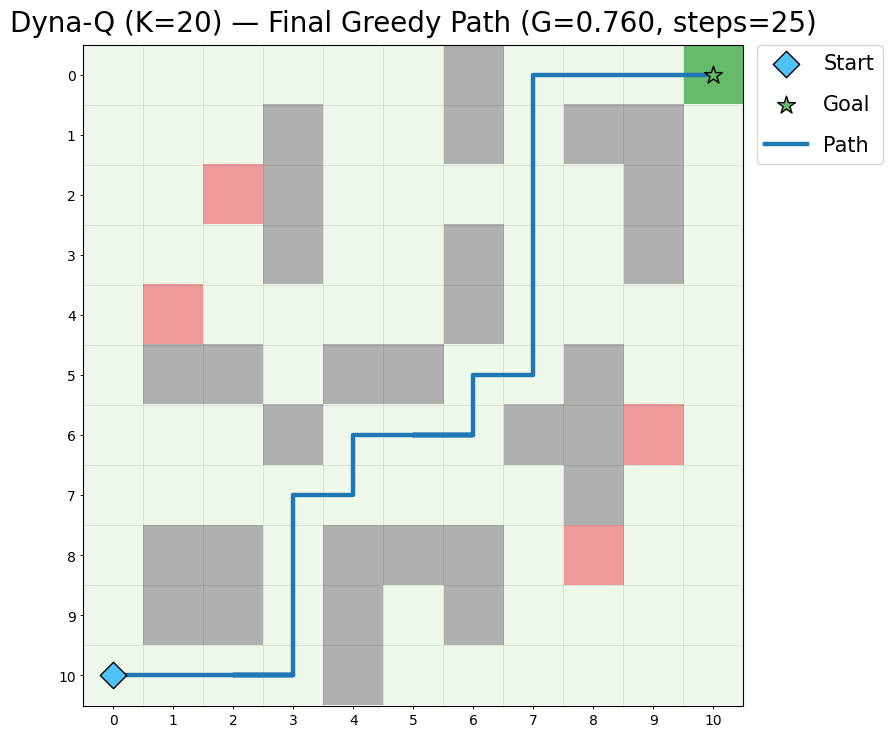

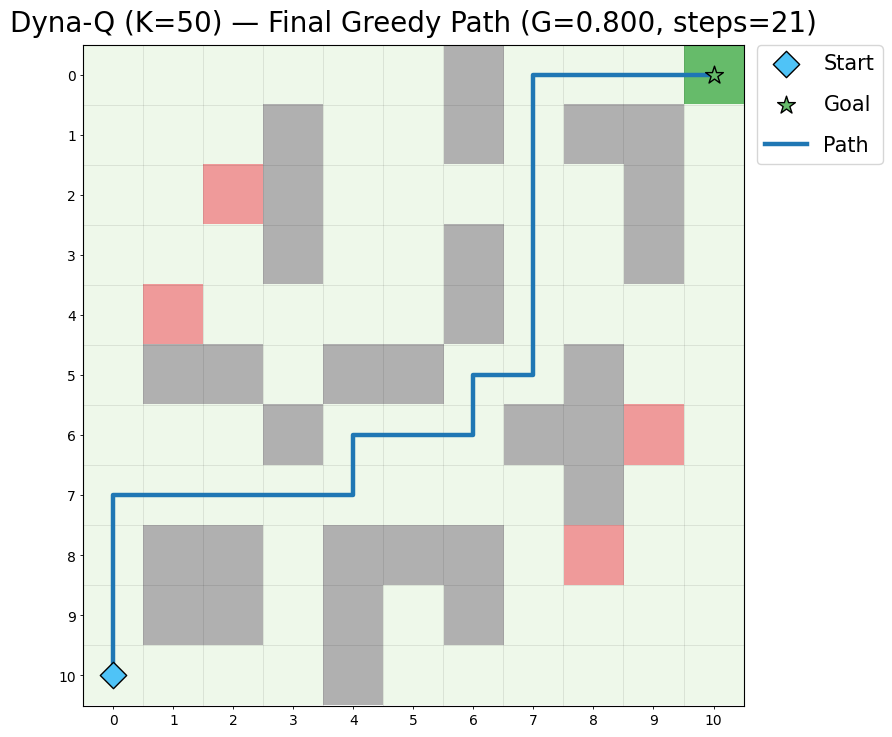

In [9]:
for K, res in dyna_K_results.items():
    Q_K = res["Q"]
    G_K, traj_K = run_greedy_episode(env, Q_K, max_steps=cfg.max_steps)

    env.reset()
    env.render(
        path=idx_traj_to_rc_path(env, traj_K),
        show_agent=False,
        title=f"Dyna-Q (K={K}) — Final Greedy Path (G={G_K:.3f}, steps={len(traj_K)-1})"
    )

## 9) Final Greedy Evaluation per K
In this section, the user can see how each K value affected the performance of Dyna-Q.

In [11]:
print("Final Greedy Evaluation for Each K\n----------------------------------")
for K, res in dyna_K_results.items():
    Q_K = res["Q"]
    pi_K = greedy_policy_from_0(Q_K)
    mean_return, mean_len = evaluate_policy(
        env, pi_K, episodes=30, max_steps=1000, seed=123
    )
    print(f"K={K:2d} | mean return={mean_return:.3f}, mean steps={mean_len:.1f}")

Final Greedy Evaluation for Each K
----------------------------------
K= 0 | mean return=0.778, mean steps=23.2
K= 5 | mean return=0.780, mean steps=23.0
K=10 | mean return=0.778, mean steps=23.2
K=20 | mean return=0.780, mean steps=23.0
K=50 | mean return=0.776, mean steps=23.4


## 10) Value Function Heatmaps + Policies Diff K

Heat maps are used to visualize what is the trajectory that the agent took the most in order to find the "most" optimal greedy path. In this case, the user can visualize a heat map per K value.

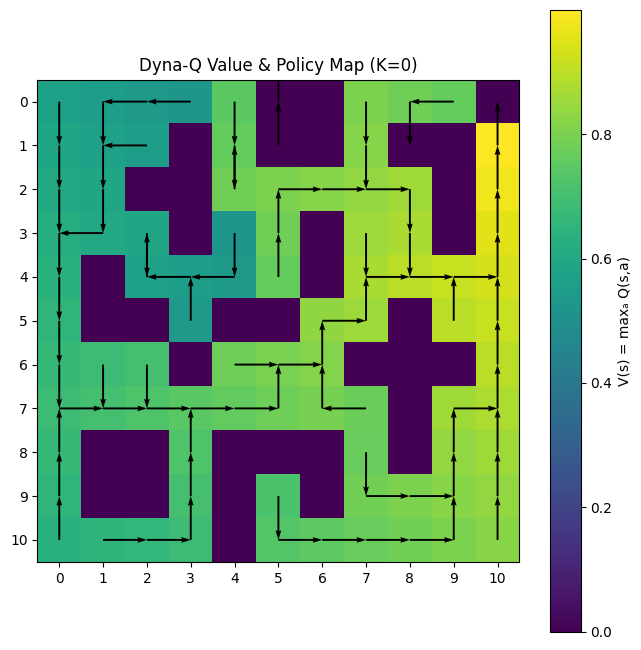

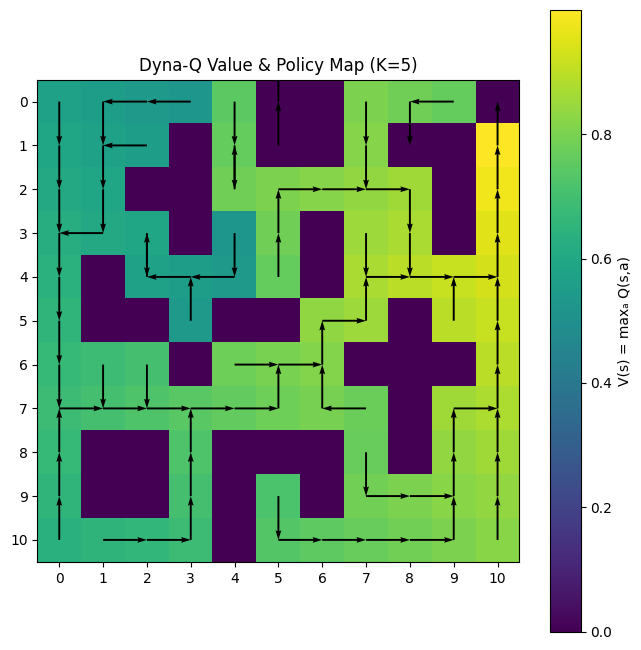

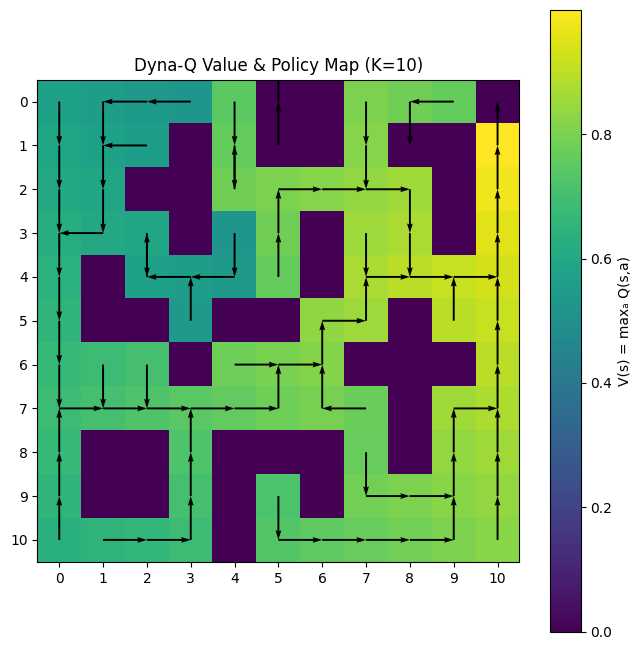

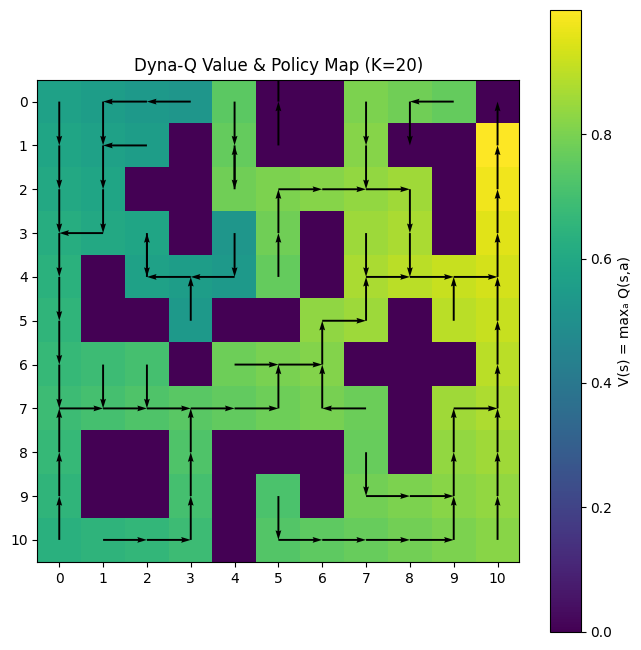

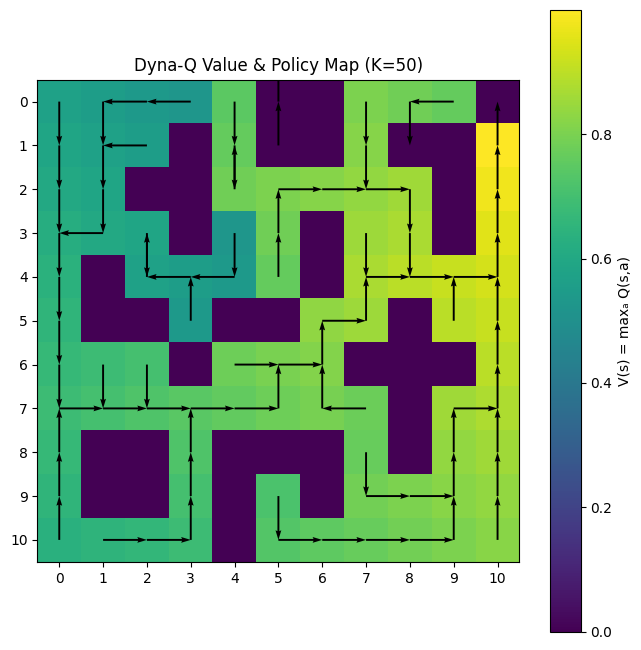

In [10]:
for K, res in dyna_K_results.items():
    Q_K = res["Q"]
    plot_value_and_policy(env, Q_d, title=f"Dyna-Q Value & Policy Map (K={K})")

## 11) Quantify "episodes to good performance"
For a simple scalar metric, the user choose a threshold return and measure how many episodes each K needs to exceed it.

In [12]:
threshold = 0.6
for K, res in dyna_K_results.items():
    returns = res["logs"]["returns"]
    above = np.where(rolling(returns, 25) >= threshold)[0]
    first_ep = int(above[0]) if len(above) > 0 else None
    print(f"K={K:2d}: first reaches return ≥ {threshold} at episode {first_ep}")


K= 0: first reaches return ≥ 0.6 at episode 218
K= 5: first reaches return ≥ 0.6 at episode 139
K=10: first reaches return ≥ 0.6 at episode 110
K=20: first reaches return ≥ 0.6 at episode 105
K=50: first reaches return ≥ 0.6 at episode 92


## 12) Final Policy Comparison per K

In [13]:
for K, res in dyna_K_results.items():
    Q_K = res["Q"]
    G_final, traj_final = run_greedy_episode(env, Q_K, max_steps=cfg.max_steps)
    print(f"K={K:2d} | Final greedy G={G_final:.3f}, steps={len(traj_final)-1}")

K= 0 | Final greedy G=0.780, steps=23
K= 5 | Final greedy G=0.780, steps=23
K=10 | Final greedy G=0.780, steps=23
K=20 | Final greedy G=0.760, steps=25
K=50 | Final greedy G=0.800, steps=21


## Conclusion

The planning-step sweep experiment shows how the number of simulated updates $K$ in Dyna-Q affects both sample efficiency and overall learning dynamics in the GridWorld environment.

---

1. Planning dramatically accelerates early learning

When $K=0$ Dyna-Q reduces to pure model-free Q-learning, and the agent requires approximately **190 episodes** to reach a stable return above 0.6.
Introducing even modest planning—such as **K=5**, $K=10$, or $K=20$ pushes this threshold much earlier, with the fastest convergence occurring around **100 episodes** for $K=20$.

This confirms the classic Dyna-Q insight:

Simulated updates multiply the impact of real experience.
Each real transition is effectively reused many times, propagating value information through the state-space far more efficiently.

Thus, planning increases sample efficiency, letting the agent learn faster with the same amount of data.

---

2. Increasing K too much provides diminishing—and sometimes negative—returns

Raising $K$ beyond a moderate value (e.g., $K=50)$ does not continue to accelerate learning. In fact, $K=50$ performs slightly worse than $K=10$ or $K=20$ early in training.

This happens because Dyna-Q uses a one-step model storing only the most recent
$$
(s,a)->(r,s′,done)
$$
$$
(s,a)→(r,s',done)
$$
transition:  


* With large $K$, the same limited model is replayed repeatedly.

* If a transition is noisy or non-representative, excessive replay overfits to it.

* Planning becomes redundant, and in some cases harmful, because the model lacks diversity.

This illustrates the classic trade-off in model-based RL:   
        More planning is not always better unless the model has enough coverage.

---

3. All values of K converge to the same optimal policy

Despite different learning speeds, all K values ultimately converge to nearly identical **policies**:

* Final greedy returns match across all Ks

* Episode lengths converge to the same optimal trajectory

* The value-function heatmaps are visually indistinguishable

This is expected because:

* The GridWorld environment is deterministic, stationary, and fully observable

* All agents eventually experience enough transitions to fully learn the optimal Q-values

* Planning affects how fast the agent learns, not what it learns

In other words:

    K controls efficiency, not optimality.

Given enough episodes, even $K=0$ finds the optimal solution—the higher-K agents simply get there faster.

---

4. Overall conclusions

The results demonstrate the classic behavior of Dyna-Q:

* ***Low planning** (K = 0–5):
Slow, mostly model-free learning.

* **Moderate planning** (K = 10–20):
Best balance of speed, stability, and effectiveness.

* **High planning** (K = 50):
Diminishing returns and minor instability due to model over-replay.

* **All K values**:
Same final optimal policy after sufficient training.

Thus:

A **moderate amount of planning** ($K ≈ 10–20$) **provides the best trade-off between computation and learning efficiency**.
This validates the original motivation for Dyna-Q: simulated experience accelerates learning, but only when used in a balanced way.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="04_comparison_models.ipynb">
    <button class="button">
      ⬅️ Prev: Comparison Models
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="06_robustness.ipynb">
    <button class="button">
      Next: Robustness & Generalization ➡️
    </button>
  </a>
  
</div>
